# 1 Import Packages

In [1]:
import numpy as np
import xarray as xr

from clim_xai_benchmark import surrogate_data_generator as clim_sdg
from clim_xai_benchmark import piecewise_synthetic_response as clim_psr
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

/home/bjoern/anaconda3/envs/xai_benchmark/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33269 instead
  warnings.warn(


# 2 Load Data

In [3]:
data = xr.open_dataarray("../data/input_data_2.nc")
covariance =xr.open_dataarray("../data/covariance_2.nc")

In [4]:
data = data.stack(feature=("lat","lon"))
covariance = covariance.stack({"feature":("lat","lon"),"feature_1":("lat_1","lon_1")})

In [5]:
breaking_points = clim_psr.gen_piecewise_linear_parameters(data, covariance, n_breaking_points=5)

In [6]:
breaking_points.unstack().to_netcdf("../data/breaking_points.nc")

In [7]:
data_output = clim_psr.cal_output_linear_piecewise(data, breaking_points= breaking_points)

In [8]:
data_output.unstack().to_netcdf("../data/output_data_2.nc")

In [9]:
feature_index=89

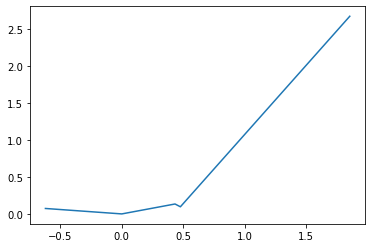

In [10]:
plt.plot(breaking_points.x.isel(feature=feature_index),breaking_points.y.isel(feature=feature_index))

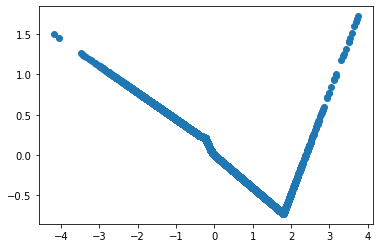

In [22]:
plt.scatter(data.isel(feature=feature_index),data_output.isel(feature=feature_index))


In [ ]:
data_output.isel(feature=feature_index)

In [ ]:
def cal_output_linear_piecewise(data, breaking_points, breaking_dim ="breaking_point", sample_dim="sample", feature_dim ="feature"):
    arr = []
    n_feature = data.sizes[feature_dim]

    for feature_index in range(n_feature):
        input_data = data.isel(feature=feature_index)
        x_start = breaking_points.isel(feature=feature_index).y.dropna(dim = breaking_dim)
        y_start = breaking_points.isel(feature=feature_index).y.dropna(dim = breaking_dim)
        slope =   breaking_points.isel(feature=feature_index).slopes

        tmp_data = piecewise_combined(
        input_data.values,
        x_start.values,
        y_start.values,
        slope.values)

        tmp_data = xr.DataArray(tmp_data, dims=[sample_dim], coords = {sample_dim:input_data.coords[sample_dim]})
        tmp_data = tmp_data.assign_coords({feature_dim:feature_index})
        arr.append(tmp_data)

    result = xr.concat(arr, dim = feature_dim)
    return result



In [ ]:
piecewise_combined(data_stack.isel(feature=0),breaking_point)

<xarray.Dataset>
Dimensions:         (breaking_point: 3, feature: 648)
Coordinates:
  * breaking_point  (breaking_point) int64 -1 0 1
  * feature         (feature) MultiIndex
  - lat             (feature) int64 -90 -90 -90 -90 -90 -90 ... 80 80 80 80 80
  - lon             (feature) int64 -180 -170 -160 -150 -140 ... 140 150 160 170
Data variables:
    x               (breaking_point, feature) float64 nan nan nan ... nan nan
    y               (breaking_point, feature) float64 nan nan nan ... nan nan
    slopes          (breaking_point, feature) float64 -0.2553 -0.1318 ... 1.919